**Exercise 3:** Tackle the Titanic dataset. A great place to start is on Kaggle. Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files, train.csv and test.csv, which you can load using pandas.read_csv(). The goal is to train a classifier that can predict the Survived column based on the other columns.

In [1]:
# Load in the data
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://homl.info/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter="data")
    return (pd.read_csv(Path("datasets/titanic/train.csv")), pd.read_csv(Path("datasets/titanic/test.csv")))

titanic_train, titanic_test = load_titanic_data()

In [2]:
# Found the following feature descriptions from Kaggle
# embarked  -   Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
# sibsp     -   Number of siblings / spouses aboard the Titanic
# parch	    -   Number of parents / children aboard the Titanic	

titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Let's build simple pipelines for numerical & categorical columns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot_encoder", OneHotEncoder(sparse_output=False))
])

num_attrs = ["Age", "SibSp", "Parch", "Fare"]
cat_attrs = ["Pclass", "Sex", "Embarked"]

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attrs),
    ("cat", cat_pipeline, cat_attrs)
])

In [5]:
# Run the training data through the pipeline
X_train = preprocessing.fit_transform(titanic_train)
y_train = titanic_train["Survived"]

In [6]:
# Let's try a couple of models to begin with (an SVM & a random forest)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

svc_clf = SVC(gamma="auto")
ranfor_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [7]:
# Let's use cross validation to see how the models do within the test set
from sklearn.model_selection import cross_val_score

svc_score = cross_val_score(svc_clf, X_train, y_train, cv=10)
ranfor_score = cross_val_score(ranfor_clf, X_train, y_train, cv=10)

In [13]:
# Print the mean accuracy
print(f"SVC:    {svc_score.mean()*100:.2f}%")
print(f"RF:     {ranfor_score.mean()*100:.2f}%")

SVC:    82.49%
RF:     81.60%


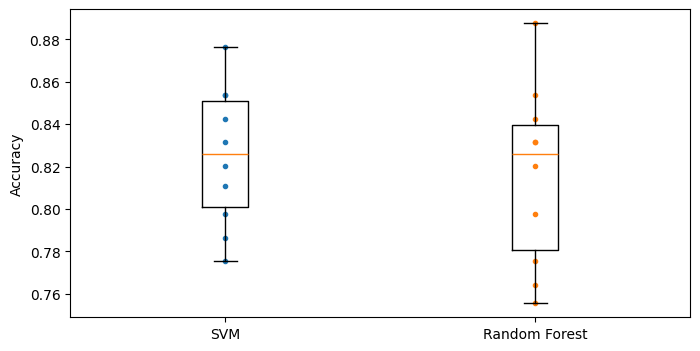

In [19]:
# It looks like the SVC does a little better, but let's see how the models perform in each of the cross validations
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot([1]*10, svc_score, ".")
plt.plot([2]*10, ranfor_score, ".")
plt.boxplot([svc_score, ranfor_score], tick_labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# In conclusion, the SVM model does on average better than the Random Forest and the performance is more stable as well which means that the performance
# will probably transfer better to the test set.